In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import h5py
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
train = h5py.File('../rec1501614399_export.hdf5', 'r')
test = h5py.File('../rec1501612590_export.hdf5', 'r')

In [ ]:
train_frames = torch.load("../vit/train_frames.pt")
test_frames = torch.load("../vit/test_frames.pt")

In [ ]:
window_size = 10

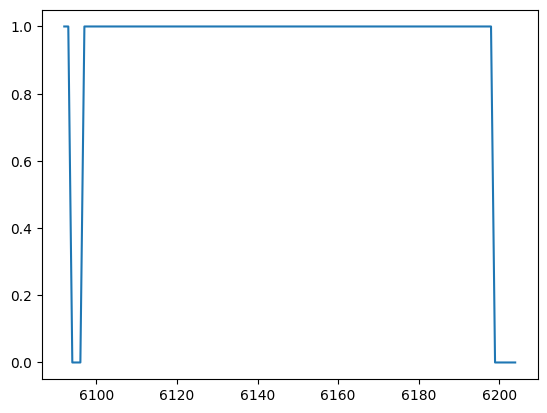

In [ ]:
train_adjusted = pd.DataFrame(columns=['accelerator_pedal_position',
                                       'brake_pedal_status',
                                       'steering_wheel_angle'])
train_adjusted['accelerator_pedal_position'] = list(train['accelerator_pedal_position'])
train_adjusted['steering_wheel_angle'] = list(train['steering_wheel_angle'])
train_adjusted['brake_pedal_status'] = list(train['brake_pedal_status'])

plt.plot(train_adjusted['brake_pedal_status'][6092:6205])
plt.show()
idx = 0
while idx < (train_adjusted.shape[0] - 2):
  if train_adjusted['brake_pedal_status'][idx] != train_adjusted['brake_pedal_status'][idx+1]:
    if train_adjusted['brake_pedal_status'][idx] == 0:
      train_adjusted.loc[idx + 1, 'brake_pedal_status'] = 0.3
      train_adjusted.loc[idx + 2, 'brake_pedal_status'] = 0.6
      train_adjusted.loc[idx +3, 'brake_pedal_status'] = 0.9
      idx = idx + 4
    elif train_adjusted['brake_pedal_status'][idx] == 1:
      train_adjusted.loc[idx +1,'brake_pedal_status'] = 0.9
      train_adjusted.loc[idx +2, 'brake_pedal_status'] = 0.6
      train_adjusted.loc[idx + 3, 'brake_pedal_status'] = 0.3
      idx = idx + 4
  else:
    idx = idx + 1


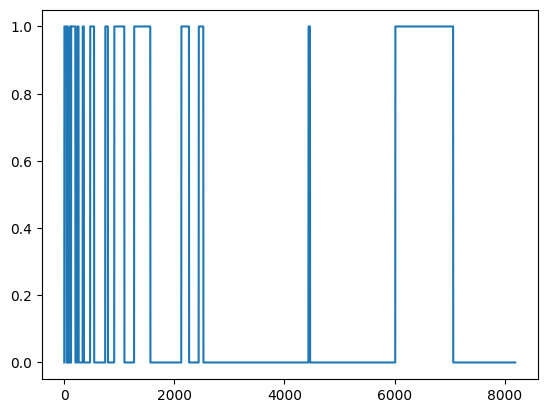

In [ ]:
test_adjusted = pd.DataFrame(columns=['accelerator_pedal_position',
                                       'brake_pedal_status',
                                       'steering_wheel_angle'])
test_adjusted['accelerator_pedal_position'] = list(test['accelerator_pedal_position'])
test_adjusted['steering_wheel_angle'] = list(test['steering_wheel_angle'])
test_adjusted['brake_pedal_status'] = list(test['brake_pedal_status'])
plt.plot(test_adjusted['brake_pedal_status'])
plt.show()
idx = 0
while idx < (train_adjusted.shape[0] - 2):
  if test_adjusted['brake_pedal_status'][idx] != test_adjusted['brake_pedal_status'][idx+1]:
    if test_adjusted['brake_pedal_status'][idx] == 0:
      test_adjusted.loc[idx + 1, 'brake_pedal_status'] = 0.3
      test_adjusted.loc[idx + 2, 'brake_pedal_status'] = 0.6
      test_adjusted.loc[idx + 3, 'brake_pedal_status'] = 0.9
      idx = idx + 4
    elif test_adjusted['brake_pedal_status'][idx] == 1:
      test_adjusted.loc[idx + 1, 'brake_pedal_status'] = 0.9
      test_adjusted.loc[idx + 2, 'brake_pedal_status'] = 0.6
      test_adjusted.loc[idx + 3, 'brake_pedal_status'] = 0.3
      idx = idx + 4
  else:
    idx = idx + 1

In [ ]:
n_heads = 8
d_model = 160 #20 * n_heads

In [ ]:
img_repr_dim = 768
class PolicyNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.sep = -1 * torch.ones(d_model, dtype=torch.float32,
                               device = device).unsqueeze(0)
    self.img_ffn = nn.Sequential(
        nn.Linear(img_repr_dim, d_model),
        nn.ReLU()
    )
    self.sensor_ffn = nn.Sequential(
        nn.Linear(3, d_model),
        nn.ReLU()
    )
    self.encoder = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads)

    # only taking the attention score for the last sensors timestamp
    self.head = nn.Sequential(
        nn.Linear(d_model, 3),
        nn.Sigmoid()
    )


  def forward(self, imgs, sensors, img_enc=None, sens_enc=None):
    imgs = self.img_ffn(imgs)
    sensors = self.sensor_ffn(sensors)
    imgs_encoded = imgs.clone().detach()
    sensors_encoded = sensors.clone().detach()

    # encoding, if needed
    if img_enc is not None:
      for idx in range(len(imgs)):
        imgs_encoded[idx] = imgs[idx].add(img_enc[idx])
    if sens_enc is not None:
      for idx in range(len(sensors)):
        sensors_encoded[idx] = sensors[idx].add(sens_enc[idx])

    x = torch.cat((imgs_encoded, self.sep, sensors_encoded), dim=0)
    x = self.encoder(x)
    x = self.head(x[-1])
    return x

In [ ]:
policyNet=PolicyNet()
policyNet.to(device)
print("done")

done


In [ ]:
criterion = nn.L1Loss()
optimizer = optim.SGD(policyNet.parameters(), lr=0.01)

In [ ]:
%%time

alpha = 0.2

num_epochs = 10
losses = []

for epoch in range(num_epochs):
  #initializing queues
  img_queue = []
  sensors_queue = []
  for i in range(len(train["accelerator_pedal_position"])):
    sensors = [train_adjusted['accelerator_pedal_position'][i]/100,
                  train_adjusted['brake_pedal_status'][i],
                  (train_adjusted['steering_wheel_angle'][i]+600)/1200]

    img = train_frames[i].squeeze(0)


    if ((len(img_queue) < window_size) or (len(sensors_queue) < window_size)):
      img_queue.append(img.tolist())
      sensors_queue.append(sensors)
      continue
    else:
      img_queue.pop(0)
      sensors_queue.pop(0)
      img_queue.append(img.tolist())
      sensors_queue.append(sensors)

    if((len(img_queue) != window_size) or (len(sensors_queue) != window_size)):
      print(len(img_queue), len(sensors_queue))
      break

    # converting queues to tensors
    img_queue_tensor = torch.tensor(img_queue, dtype=torch.float32).to(device)
    sensors_queue_tensor = torch.tensor(sensors_queue, dtype=torch.float32).to(device)

    output = policyNet(img_queue_tensor, sensors_queue_tensor[:-1])

    optimizer.zero_grad()

    loss = criterion(output, sensors_queue_tensor[-1])
    # outliers prevention
    loss = loss - alpha * torch.abs(sensors_queue_tensor[-1][1] - sensors_queue_tensor[-2][1])
    loss = torch.nn.functional.relu(loss)

    if(output.shape != sensors_queue_tensor[-1].shape):
      print(output.shape, sensors_queue_tensor[-1].shape)
      break
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
  print(f"done epoch {epoch}.")

done epoch 0.
done epoch 1.
done epoch 2.
done epoch 3.
done epoch 4.
done epoch 5.
done epoch 6.
done epoch 7.
done epoch 8.
done epoch 9.
CPU times: user 5min 34s, sys: 3.66 s, total: 5min 38s
Wall time: 5min 47s


0.01148116351669622


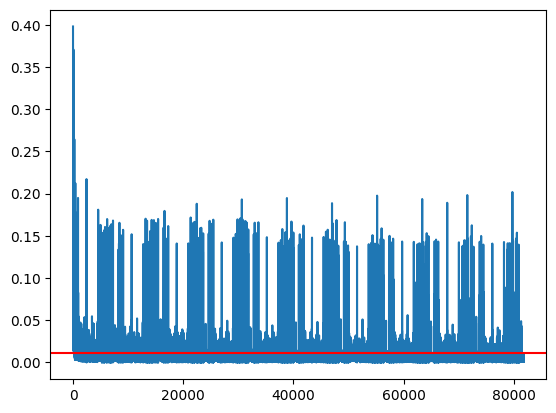

In [ ]:
print(np.mean(losses))
plt.plot(losses)
plt.axhline(np.mean(losses), color='r')
#plt.vlines([i * len(train['aps_frame'])for i in range(num_epochs)], 0, max(losses), color = 'r')
plt.show()

In [ ]:
%%time

policyNet.eval()
losses = []
predictions = []
with torch.no_grad():
  #initializing queues
  img_queue = []
  sensors_queue = []
  for i in range(len(test["accelerator_pedal_position"])):

    sensors = [test_adjusted['accelerator_pedal_position'][i]/100,
                  test_adjusted['brake_pedal_status'][i],
                  (test_adjusted['steering_wheel_angle'][i]+600)/1200]


    img = test_frames[i].squeeze(0)


    if ((len(img_queue) < window_size) or (len(sensors_queue) < window_size)):
      img_queue.append(img.tolist())
      sensors_queue.append(sensors)
      continue
    else:
      img_queue.pop(0)
      sensors_queue.pop(0)
      img_queue.append(img.tolist())
      sensors_queue.append(sensors)

    if((len(img_queue) != window_size) or (len(sensors_queue) != window_size)):
      print(len(img_queue), len(sensors_queue))
      break

    # converting queues to tensors
    img_queue_tensor = torch.tensor(img_queue, dtype=torch.float32).to(device)
    sensors_queue_tensor = torch.tensor(sensors_queue, dtype=torch.float32).to(device)

    output = policyNet(img_queue_tensor, sensors_queue_tensor[:-1])

    loss = criterion(output, sensors_queue_tensor[-1])

    loss = loss - alpha * torch.abs(sensors_queue_tensor[-1][1] - sensors_queue_tensor[-2][1])
    loss = torch.nn.functional.relu(loss)

    predictions.append(output.tolist())

    losses.append(loss.item())
    if (i % 1000) == 0:
      print(i)

1000
2000
3000
4000
5000
6000
7000
8000
CPU times: user 16.6 s, sys: 31.8 ms, total: 16.6 s
Wall time: 16.8 s


avg loss: 0.032104763661947935
max loss: 0.21640485525131226
min loss: 0.0


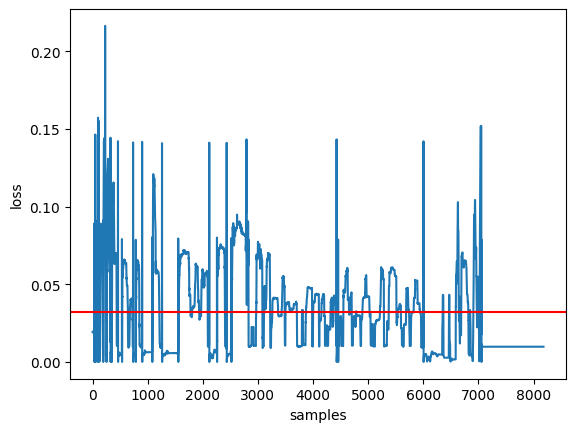

In [ ]:
print(f"avg loss: {np.mean(losses)}")
print(f"max loss: {max(losses)}")
print(f"min loss: {min(losses)}")

plt.plot(losses)
plt.axhline(np.mean(losses), color='r')
plt.xlabel("samples")
plt.ylabel("loss")
#plt.vlines([i * len(train['aps_frame'])for i in range(num_epochs)], 0, max(losses), color = 'r')
plt.show()

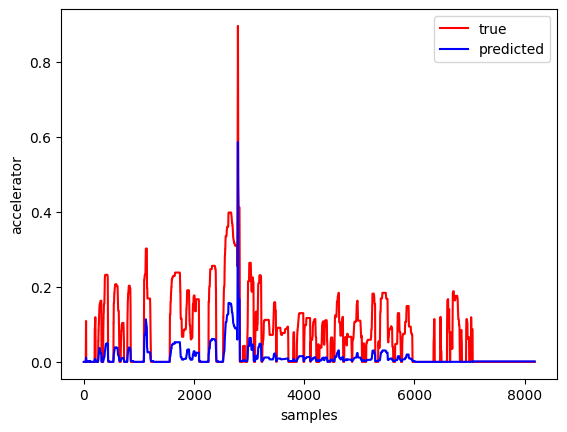

In [ ]:
accelerations = [element[0] for element in predictions]
truth = test_adjusted['accelerator_pedal_position'][window_size:].tolist()
truth = [x / 100 for x in truth]
accelerations = [x for x in accelerations]
plt.plot(truth, color='r', label='true')
plt.plot(accelerations, color='b', label='predicted')
plt.xlabel('samples')
plt.ylabel('accelerator')
plt.legend()
plt.savefig("./acc_preprocessed.png")
plt.show()

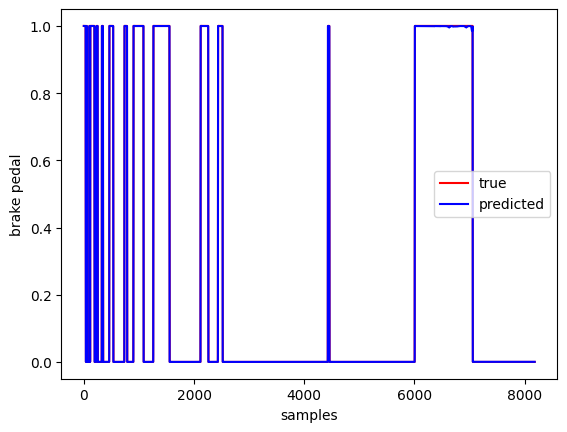

In [ ]:
brakes = [element[1] for element in predictions]
truth = test_adjusted['brake_pedal_status'][window_size:].tolist()
plt.plot(truth, color='r', label='true')
plt.plot(brakes, color='b', label='predicted')
plt.xlabel('samples')
plt.ylabel('brake pedal')
plt.legend()
plt.savefig("./brk_preprocessed.png")
plt.show()

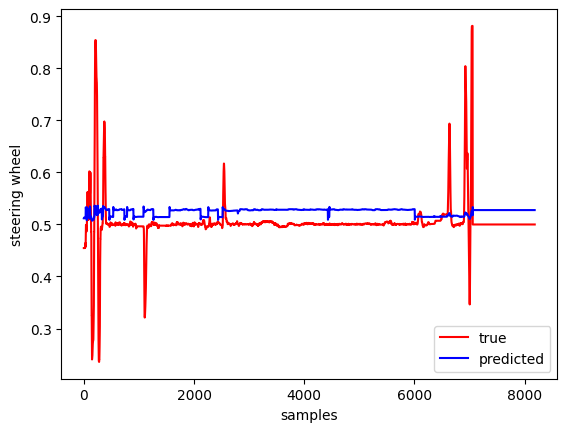

In [ ]:
steers = [element[2] for element in predictions]
truth = test_adjusted['steering_wheel_angle'][window_size:].tolist()
truth = [(x + 600) / 1200 for x in truth]
steers = [x for x in steers]
plt.plot(truth[:], color='r', label='true')
plt.plot(steers[:], color='b', label='predicted')
plt.xlabel('samples')
plt.ylabel('steering wheel')
plt.legend()
plt.savefig("./str_preprocessed.png")
plt.show()